## Radial Basis Function Interpolation

**Approximating functions with a weighted sum of Gaussians**

Radial basis function interpolation is a method of interpolating functions or data using a weighted sum of radial basis functions. One of the most widely used radial basis functions is the **Gaussian functon** which has been shown to be universal enough to approximate a wide variety of functions. In this article we will briefly explore how to interpolate scattered data points drawn from some function using a weighted sum of Gaussian functions!

### Radial Basis Functions and Gaussians

Radial basis functions are functions whose value varies only with the distance between the input value and some reference point- they have the following property: f(x) = f(||x||) where ||x|| is some distance metric such as the **Euclidean distance.**

One of the most widely used radial basis function is the Gaussian function:
f(x, μ) = a · exp(-(x - μ)² / (2σ²))

As can be seen in the figure below, the output of f(x) varies with distance between x and μ = 0, and have the property f(x) = f(||x||).

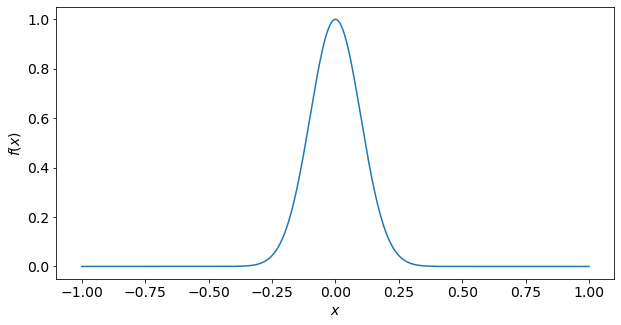

### Interpolating Functions with Gaussians

#### Mathematical Background

We will now explore briefly the mathematics of using a weighted sum of Gaussian functions to interpolate data points drawn from some function.

Assume that we have some vector d containing n data points drawn from some function ϕ(x):

d = [ϕ(x₁), ϕ(x₂), … , ϕ(xₙ)]ᵀ.

We expand the ith data point ϕ(xᵢ) as a weighted sum of Gaussian functions:
ϕ(xᵢ) =m₁ f(xᵢ, x₁) + m₂ f(xᵢ, x₂) + … + mₙ f(xᵢ, xₙ).

This expansion can be cast as the matrix product of some kernel matrix G and some model weights vector m:
d = Gm,

where the kernel matrix G is a symmetric matrix and has the elements:
G[i, j] = f(xᵢ, xⱼ) = f(xⱼ, xᵢ),

and the model weights vector m has the elements:
m = [m₁, m₂, … , mₙ]ᵀ.

With d, and G computed from the inputs xᵢ, we can invert the linear system to obtain the model weights m:

m = G⁻¹d.

With the inverted model weights m, we can then interpolate ϕ(x) for points originally not in the inputs xᵢ by using another weighted sum of Gaussians:
ϕ’(x’) = m₁ f(x’, x₁) + m₂ f(x’, x₂) + … + mₙ f(x’, xₙ).

Now that we have the mathematical background out of the way, we can implement our algorithm in Python!

### Python Code

In this section we will use Python to create a radial basis function interpolator to interpolate the function: ϕ(x) = sin(2πx) · cos(5πx).

First of all, let's define the function to draw data points from - phi takes one input x and returns the value of ϕ(x) = sin(2πx) · cos(5πx).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def phi(x):
    F = np.sin(2 * np.pi * x) * np.cos(5 * np.pi * x)
    return F

Next, we define the function which returns the value of Gaussian function - gaussian takes 2 compulsory inputs x1 and x2, and returns the value of f(x₁, x₂) = exp(-(x₁ - x₂)² / (2l²)). The optional input 1 controls the length scale of the Gaussian functions used, and will be set manually if required. 

In [2]:
def gaussian(x1, x2, l=1):
    f = np.exp(-(x1 - x2) ** 2 / (2*l**2))
    return f

Using gaussian we can compute the kernel matrix G - kernel matrix takes 1 compulsory input x which is an array containing the n values of the inputs xᵢ. kernel_matrix returns the values of G[i, j] = f(xᵢ, xⱼ). The first optional input l controls the length scale of the Gaussian functions, and the second optional input f tells kernel_matrix which radial basis functions to use. 

In [3]:
def kernel_matrix(X, l=1, f=gaussian):
    G = np.zeros([len(X), len(X)])
    for i in range(len(X)):
        for j in range(len(X)):
            G[i,j] = f(X[i], X[j], l)
    return G

Using the n data points d and the kernel matrix G, we can now invert the linear system d = Gm for the model parameters m - rbf_model takes two corresponding inputs G and d and returns an array m containing the inverted model parameters. 

In [4]:
def rbf_model(G, d):
    m = np.dot(np.linalg.inv(G), d)
    return m

With the model parameters m we can finally interpolate the values of ϕ(x) -- rbf_predict takes three compulsory inputs: x is an array of input values to interpolate, X is an array containing the original inputs xᵢ, m is the array containing the model parameters. Once again the two optional parameters l and f control the length scale of the Gaussian used, as well as which radial basis function to use. 

In [7]:
def rbf_predict(x, X, m, l=1, f=gaussian):
    S = np.zeros(len(x))
    for i in range(len(m)):
        S = S + m[i] * f(x, X[i], l)
    return S

We then generate n=10 input values of x for the range[0.0, 1.0] in steps of 0.1, and sample d the corresponding values of ϕ(x) at those input points. For now we set the Gaussian length scale to l = 1/9 . The kernel matrix G is calculated, and the model parameters m are obtained. Using m, we then interpolate the values of ϕ(x) for the other non-sampled values of x.

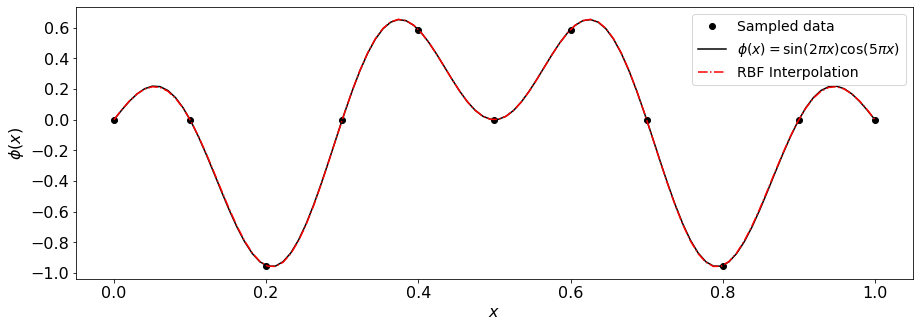

In [9]:
# Sample 10 values of X and phi
N = 10
X = np.arange(0, N+1, 1) / N
d = phi(X)

# Gaussian Length Scale
L = 1 / 9

# Calculate the kernel matrix G
G = kernel_matrix(X, L, gaussian)

# Invert d = Gm for model parameters. 
m = rbf_model(G,d)

# Using m, interpolate phi for all values in x ∈ [0, 1].
x = np.linspace(0,1,100)
S = rbf_predict(x, X, m, L, gaussian)

# Plot the results
plt.figure(figsize=[15,5])
plt.plot(X, d, "ko") # Sampled discrete data points of phi.
plt.plot(x, phi(x), "k") # True "continuous" values of phi.
plt.plot(x, S, "r-.") # Interpolated values of phi.
plt.legend(["Sampled data",
            "$\phi(x) = \sin(2 \pi x) \cos(5 \pi x)$",
            "RBF Interpolation"], fontsize=14)
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$\phi(x)$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

From the image above, we find that with 10 sample data points, the model has managed to interpolate ϕ(x) = sin(2πx) · cos(5πx) very nicely using a weighted sum of 10 Gaussians! Perhaps it might be a good idea to take a look at what those 10 Gaussians look like.

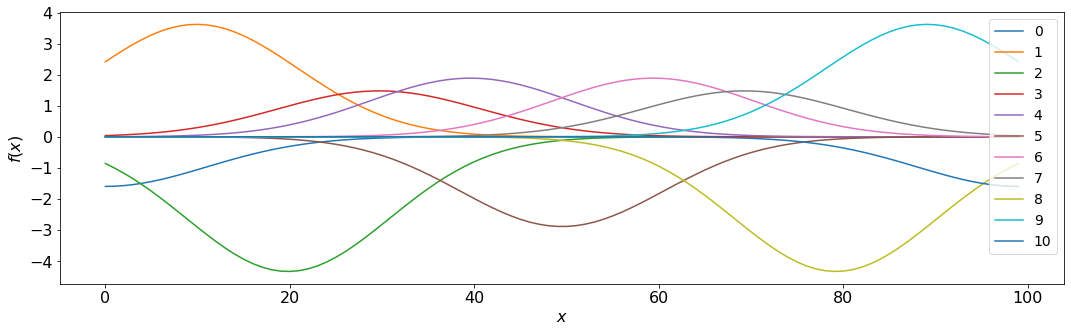

In [10]:
# Plotting the 10 weighted Gaussians used in the interpolation model.
plt.figure(figsize=[18,5])
for i in range(len(m)):
    plt.plot(m[i] * gaussian(x, X[i], L))
plt.legend(range(len(m)), fontsize=14)
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$f(x)$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

We find that ϕ(x) = sin(2πx) · cos(5πx) which is symmetric about x = 0.5, is interpolated by a set of Gaussians which are equally weighted about x = 0.5.

### Closing Remarks

In this article we explored how to use the Gaussian functions to interpolate a trigonometric function. Radial basis function interpolation is an extremely powerful interpolation method, and although we only explored the interpolation of a one dimensional function using Gaussian in this tutorial, this method can be further extended to perform stable and accurate interpolations of higher dimensional functions. 